_ __Capstone #1:__ Prep Course Capstone Analytic Report_

 ---------

# <span style="color:darkblue">Exploratory Analysis of Box Office Movies by Genre</span>

__Author:__ Ryan Harper 

--------

# <span style="color:darkblue">Overview</span>

__Data Source:__ https://www.kaggle.com/tmdb/tmdb-movie-metadata/data
<br>__Original Source:__ https://www.themoviedb.org

The data set in this notebook contains information about movies listed on IMDB. It includes categorical variables (genre, language, country), discrete variables (ratings), and continuous variables (budget and revenue).  The data was pulled from www.themoviedb.org and posted on the www.kaggle.com website. This analysis looks at the movie's __genre__, __budget__, and __gross profits__ to help investors decide which movies are more likely to be financially successful at the box office.

__Questions:__
>__Question 1:__ Do movie genres vary from one another? In what ways?<br>
__Question 2:__ What is the distribution of gross per genre?<br>
__Question 3:__ Is there a relationship between budget and gross profits per genre?

# <span style="color:darkblue">Results</span>

__Answers:__
> __Answer 1:__ Sample sizes vary significantly between genres (may reflect the overall industry or just a result of scraped data). There are significant differences between genres with regards to average gross profits but this might also be impacted by average budget. Animation films appear to have the best gross profit between the inner and upper quartile range. Romance, Horror, and Music genres seem to trend towards a positive gross profit albeit their upper quartile ranges are smaller than other high grossing genres. The lower quartile range of Action and Adventure genres seem to show a larger range of financial loss. <br><br>
__Answer 2:__ Based on the histogram plots, most genres appear to be left skewed. Exponential curves in QQ plots indicates most genres are left skewed. Animation appears more linear so it could have a normal distribution.<br><br>
__Answer 3:__ Action, Fantasy, Science Fiction genres have the highest correlation between budget and profit. Western, Horror, War, and History genres have low correlation between budget and profit

__Hypotheses:__ 
> __Hypothesis 1: __There is a difference between Action and Animation genre samples for gross profits. <br>
__Hypothesis 2: __Budget and genre correlate with gross. <br> __Hypothesis 3: __Animation films have the best gross profit potential depending on budget.

__Further Research:__
 
> __Question:__ Can gross profits for a movie be predicted using features like budget and genre?<br>
<br>__Model 1:__ Use a linear regression model on budget and genre to predict gross profits. I would split genres (with sample sizes greater than 500) using train_test_split and plot a linear regression.<br>
<br>__Model 2:__ Use Naive Bayes neural network with a few features from the IDMB set (including genre) to predict gross profits and to determine which features are the most significant. I would clean up the other features in the dataset (language, production studio, and runtime) and run the NBNN to see if box office profits can be determined.


__Difficulties:__ 
><li>Using the scientific method<li>Organizing presentation of the data<li>Financial data (budget/revenue/gross) was left skewed (nonparametric)<li>Sample sizes for genre varied dramatically<li>Plotting 20 genres with subplots was logistically difficult<li>Scatter plots for budget and gross profits are misleading (with regards to the y-axis and diminishing returns)

----------

# <span style="color:darkblue">Part 1: Cleaning Data</span>

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
from matplotlib.pyplot import subplots, show
import ast
import math
from scipy.stats import ttest_ind, mannwhitneyu, median_test
from IPython.display import display
from IPython.core.debugger import Tracer

%matplotlib inline

In [2]:
# change optional settings for libraries
sns.set_style("whitegrid")
pd.set_option('show_dimensions', False)
np.warnings.filterwarnings('ignore')

__Created 'gross' column and deleted unused columns:__

In [3]:
# import data, add gross profit column, and delete homepage/overview columns
moviedata = pd.read_csv('tmdb_5000_movies.csv', encoding = "ISO-8859-1") 
moviedata['gross'] = moviedata['revenue'] - moviedata['budget']
del moviedata['homepage']
del moviedata['overview']
del moviedata['original_title']

__Values in some columns printed out the data as a dictionary within a string:__

In [4]:
#rows include values that are strings with dictionaries inside
print(moviedata.iloc[1]['genres'])
print(moviedata.iloc[1]['production_countries'])
print(moviedata.iloc[1]['production_companies'])

[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]
[{"iso_3166_1": "US", "name": "United States of America"}]
[{"name": "Walt Disney Pictures", "id": 2}, {"name": "Jerry Bruckheimer Films", "id": 130}, {"name": "Second Mate Productions", "id": 19936}]


__Functions to interpret data embedded in the dict-like strings:__

In [5]:
def find_set(seriesvalue):
    # function for returning list of unique values in column
    unique=[]
    for seriesvalue in seriesvalue:
        seriesvalue = ast.literal_eval(seriesvalue)
        for fulldict in seriesvalue:
            # The key for the dict values is 'name'
            if 'name' in fulldict:
                unique.append(fulldict['name'])          
    return set(unique)

def name_fix(seriesvalue):
    # function for converting dictionaries to simple lists in columns
    try:
        seriesvaluelist=[]
        seriesvalue = ast.literal_eval(seriesvalue)
        for valuedict in seriesvalue:
            if 'name' in valuedict:
                seriesvaluelist.append(valuedict['name'])
        return ', '.join(seriesvaluelist)
    except (SyntaxError, ValueError, TypeError) as e:
        return seriesvalue

In [6]:
# creates list of unique values for specific columns with string data
un_genre = list(find_set(moviedata.genres))
un_country = list(find_set(moviedata.production_countries))
un_language = list(find_set(moviedata.spoken_languages))
un_keywords = list(find_set(moviedata.keywords))
un_companies = list(find_set(moviedata.production_companies))

In [7]:
# runs the name fix function to make the dataset easier to read
for column in moviedata:
    moviedata[column] = moviedata[column].apply(name_fix)

__Data Summary:__

In [8]:
# reporting of data
print("TOTAL MOVIES: {}".format(moviedata['id'].count()))
print("COUNTRIES: {}, GENRES: {}, LANGUAGES: {}, COMPANIES: {}".format(len(un_country),len(un_genre),len(un_language),len(un_companies)))
print("BUDGET MAX: ${:,.2f} REVENUE MAX: ${:,.2f} GROSSING MAX: ${:,.2f}".format(moviedata['budget'].max(),moviedata['revenue'].max(),moviedata['gross'].max()))    
print("BUDGET MEAN: ${:,.2f} REVENUE MEAN: ${:,.2f} GROSSING MEAN: ${:,.2f}\n".format(moviedata['budget'].mean(),moviedata['revenue'].mean(),moviedata['gross'].mean()))          
display(moviedata.iloc[0:2], moviedata.info())

TOTAL MOVIES: 4803
COUNTRIES: 88, GENRES: 20, LANGUAGES: 62, COMPANIES: 5017
BUDGET MAX: $380,000,000.00 REVENUE MAX: $2,787,965,087.00 GROSSING MAX: $2,550,965,087.00
BUDGET MEAN: $29,045,039.88 REVENUE MEAN: $82,260,638.65 GROSSING MEAN: $53,215,598.78

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 18 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title   

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,gross
0,237000000,"Action, Adventure, Fantasy, Science Fiction",19995,"culture clash, future, space war, space colony...",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",1987,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,2550965087
1,300000000,"Adventure, Fantasy, Action",285,"ocean, drug abuse, exotic island, east india t...",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,661000000


None

_There are 4,803 movies, 20 genres, 88 countries, 62 languages, and 5,017 companies.<br>The highest budget is  \$380,000,000.00. <br>The highest revenue is \$2,787,965,087.00. <br>The highest grossing movie was  \$2,550,965,087.00 (Avatar)._

__Movies and genres without budget or revenue data needed to be removed from the analysis:__

In [9]:
# remove data without budget/revenue
moviedata = moviedata.loc[(moviedata['budget'] != 0) & (moviedata['revenue'] != 0)]
if 'Foreign' in un_genre:
    un_genre.remove('Foreign')
    
if 'TV Movie' in un_genre:
    un_genre.remove('TV Movie')

__Looped through genre list to create genre columns with boolean values:__

In [10]:
# creates temp columns for True/False check of each genre and deletes main genre column
for column in un_genre:
    moviedata[column] = moviedata.genres.apply(lambda value: column in value)    
del moviedata['genres']

In [11]:
# creates new dataframes for each genre and puts into dict
genres = {}

for column in un_genre:
    df = moviedata[moviedata[column] == True]
    genres[column] = df.drop(un_genre, axis=1, inplace=False)    

#  <span style="color:darkblue">Part 2: Genre Summary Statistics</span>

__Sort genres into new dataframes and calculate the average, count, standard deviation of numerical data:__

In [12]:
# creates a new dataframe based on genres
genrestats = {}
intcolumns = ['budget','revenue','gross','vote_average']
for col in intcolumns:
    poplist = []
    for genre in un_genre:
        poplist.append(moviedata[genre] == True)

    avglist = []
    devlist = []
    cntlist = []
    for ser in poplist:
        avglist.append(moviedata.loc[ser, col].mean())
        devlist.append(moviedata.loc[ser, col].std())
        cntlist.append(moviedata.loc[ser, col].count())
        
    genrestats[col+'_avg'] = avglist
    genrestats[col+'_std'] = devlist
    genrestats[col+'_cnt'] = cntlist

dfGenre = pd.DataFrame(genrestats, index=un_genre)
display(dfGenre,dfGenre.describe())

,budget_avg,budget_cnt,budget_std,gross_avg,gross_cnt,gross_std,revenue_avg,revenue_cnt,revenue_std,vote_average_avg,vote_average_cnt,vote_average_std
Adventure,7.689239e+07,661,6.277496e+07,1.707142e+08,661,2.566121e+08,2.476065e+08,661,2.953000e+08,6.235250,661,0.862386
Thriller,4.095393e+07,935,3.892819e+07,6.923375e+07,935,1.334463e+08,1.101877e+08,935,1.578563e+08,6.206845,935,0.801762
Comedy,3.615545e+07,1110,3.503618e+07,7.232391e+07,1110,1.244804e+08,1.084794e+08,1110,1.444405e+08,6.080631,1110,0.833709
Horror,2.055763e+07,332,2.355402e+07,4.716959e+07,332,6.874178e+07,6.772722e+07,332,7.839788e+07,5.902410,332,0.823151
History,3.775487e+07,145,3.495982e+07,4.016241e+07,145,8.023771e+07,7.791728e+07,145,9.174953e+07,6.800690,145,0.661070
War,4.098456e+07,120,3.746079e+07,5.979416e+07,120,1.087265e+08,1.007787e+08,120,1.224240e+08,6.792500,120,0.786991
Crime,3.475472e+07,521,3.295340e+07,5.314782e+07,521,9.873133e+07,8.790254e+07,521,1.204301e+08,6.434165,521,0.807622
Romance,2.829866e+07,574,2.749864e+07,6.426381e+07,574,1.266034e+08,9.256247e+07,574,1.403881e+08,6.351916,574,0.804387
Western,3.548164e+07,57,4.968987e+07,3.029081e+07,57,9.920226e+07,6.577245e+07,57,1.128346e+08,6.671930,57,0.890175
Documentary,5.422902e+06,38,7.435102e+06,2.040826e+07,38,3.394283e+07,2.583116e+07,38,3.607979e+07,6.842105,38,0.753597


,budget_avg,budget_cnt,budget_std,gross_avg,gross_cnt,gross_std,revenue_avg,revenue_cnt,revenue_std,vote_average_avg,vote_average_cnt,vote_average_std
count,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,18.000000,18.000000,18.000000
mean,4.444062e+07,475.222222,4.016308e+07,8.647719e+07,475.222222,1.451377e+08,1.309178e+08,475.222222,1.667123e+08,6.383009,475.222222,0.821611
std,2.155805e+07,398.711093,1.561344e+07,5.395883e+07,398.711093,7.159614e+07,7.463068e+07,398.711093,8.254546e+07,0.274666,398.711093,0.067904
min,5.422902e+06,38.000000,7.435102e+06,2.040826e+07,38.000000,3.394283e+07,2.583116e+07,38.000000,3.607979e+07,5.902410,38.000000,0.661070
25%,3.120732e+07,155.750000,3.199760e+07,5.224442e+07,155.750000,9.884906e+07,7.978989e+07,155.750000,1.147335e+08,6.172247,155.750000,0.790684
50%,3.826033e+07,353.500000,3.624848e+07,6.378596e+07,353.500000,1.197541e+08,1.014263e+08,353.500000,1.371957e+08,6.358034,353.500000,0.817801
75%,6.270817e+07,639.250000,5.293592e+07,1.230737e+08,639.250000,2.170936e+08,1.857819e+08,639.250000,2.490537e+08,6.576691,639.250000,0.883228
max,8.082671e+07,1441.000000,6.354801e+07,1.980907e+08,1441.000000,2.575484e+08,2.789174e+08,1441.000000,2.981470e+08,6.842105,1441.000000,0.908440


_Counts for each genre are the same for budget, revenue, and gross so there does not appear to be immediate issues with null values. Averages between genres with regards to budget, revenue, and gross appear to vary, but movie counts per genre also vary significantly. _

_ __Answer to Q1:__ Sample sizes vary significantly between genres (may reflect the overall industry or just a result of scraped data). There are significant differences between genres with regards to average gross profits but this might also be impacted by average budget._

#  <span style="color:darkblue">Part 3: Distribution of <span style="color:darkred">Gross</span> Per Genre

__A. Histogram__

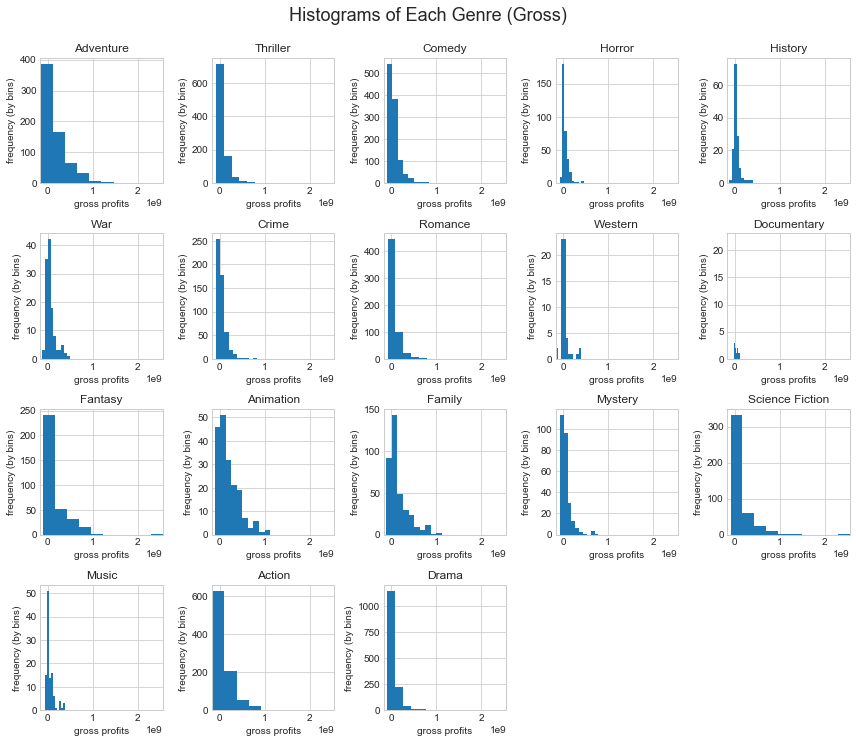

In [13]:
# hist plot of diff genres gross profits
i = 1
fig=plt.figure(figsize=(12,12))

xmin = moviedata['gross'].min()
xmax = moviedata['gross'].max()
for genre in genres:
    plt.subplot(5, 5, i)
    
    i = i + 1
    plt.hist(genres[genre]['gross'],bins=10)
    plt.xlim(xmin,xmax)
    plt.xlabel('gross profits')
    plt.ylabel('frequency (by bins)')
    plt.title(genre)

fig.suptitle('Histograms of Each Genre (Gross)', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

_ __Answer to Q2:__ Based on the histogram plots, most genres appear to be left skewed._

__B. QQ Gaussian Plot__

In [14]:
def plot_qq(series, loc=1,color='royalblue'):
    # creating random normal sampling for qq plot
    norm = np.random.normal(0, 1, series.count())

    # Sorting the values in ascending order.
    norm.sort()
    series = series.sort_values()
    
    # Plotting a genre sample against norm in qqplot.
    plt.subplot(5, 5, loc)
    plt.plot(norm, series, "o", color =color)
    
# --currently not used
def plot_qqneat(series):
    # example qq plot
    a = np.random.normal(5,5,250)
    b = np.random.rayleigh(5,250)

    percs = np.linspace(0,100,21)
    qn_a = np.percentile(a, percs)
    qn_b = np.percentile(b, percs)

    plt.plot(qn_a,qn_b, ls="", marker="o")

    x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
    plt.plot(x,x, color="k", ls="--")

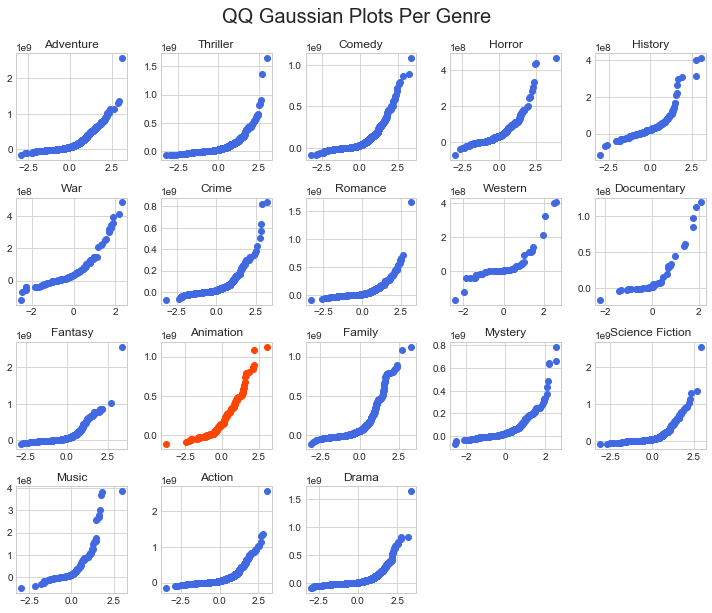

In [15]:
# qq plots of genres
i = 1
fig=plt.figure(figsize=(10,10))

for genre in genres:
    if genre == 'Animation':
        plot_qq(genres[genre]['gross'],i,'orangered')
    else:
        plot_qq(genres[genre]['gross'],i)
    i = i + 1
    plt.title(genre)

fig.suptitle('QQ Gaussian Plots Per Genre', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

_ __Answer to Q2:__ Exponential curves in QQ plots indicates most genres are left skewed. Animation appears more linear so it could have a normal distribution._

__C. Box Plot__

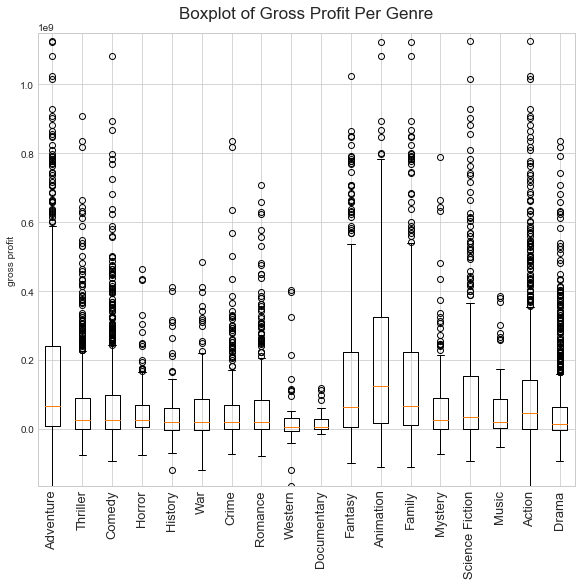

In [16]:
def ser_con(genre): return list(genres[genre]['gross'])

plt.figure(figsize=(8,8))
plt.boxplot(list(map(ser_con, un_genre)))
# Tracer()()
plt.xticks(list(range(1,19)), un_genre, rotation=90, fontsize=13)
plt.ylim(moviedata['gross'].min(), moviedata['gross'].max()*.45)
plt.tight_layout()
plt.ylabel('gross profit')
plt.title('Boxplot of Gross Profit Per Genre', fontsize=17,y=1.02)
plt.show()

_ __Answer to Q1:__ Animation films appear to have the best gross profit between the inner and upper quartile range. Romance, Horror, and Music genres seem to trend towards a positive gross profit albeit their upper quartile ranges are smaller than other high grossing genres. The lower quartile range of Action and Adventure genres seem to show a larger range of financial loss._

# <span style="color:darkblue">Part 4: Comparing Genre Samples</span>

> __Hypothesis 1: __There is a difference between gross for Action and Animation genres

__A. Descriptive Comparison__

In [17]:
# reviewing Action for outliers
print('Action mean: {}'.format(genres['Action']['gross'].mean()))
print('Action median: {}'.format(genres['Action']['gross'].median()))
print('Action standard deviation: {}'.format(genres['Action']['gross'].std()))
print('Action median absolute deviation: {} \n'.format(genres['Action']['gross'].mad()))

# reviewing Animation for outliers
print('Animation mean: {}'.format(genres['Animation']['gross'].mean()) )
print('Animation median: {}'.format(genres['Animation']['gross'].median()))
print('Animation standard deviation: {}'.format(genres['Animation']['gross'].std()))
print('Animation median absolute deviation: {} \n'.format(genres['Animation']['gross'].mad()) )

Action mean: 114424359.2124183
Action median: 45189732.0
Action standard deviation: 208691170.02048752
Action median absolute deviation: 131949754.11423638 

Animation mean: 198090651.15957448
Animation median: 125484869.5
Animation standard deviation: 239603756.6458052
Animation median absolute deviation: 187096755.07435438 



_ __Answer to Q1:__ When compared to the action genre, the Animation genre has a comparatively large median absolute deviation and will be more inclusive of outliers_

__B. T-test (Parametric A/B Independent Samples)__

In [18]:
#Ex T-Test with scipy for parametric, (equal_var=True because same population)
t, p = ttest_ind(genres['Animation']['gross'], genres['Action']['gross'], equal_var=True)
print('tvalue: {}, pvalue:{}'.format(t,p))

tvalue: 4.87831783017246, pvalue:1.2269553049791973e-06


_P-value is less than 5%. Indicates variation between the Animation and Action. T-value is 4.878 (a little low)_

In [19]:
# T-Test Raw Calculation for parametric data (assuming different population?)

# Compute the difference between the two sample means.
diff=dfGenre.loc['Animation','gross_avg'] - dfGenre.loc['Action','gross_avg']

# size of samples
size = np.array([dfGenre.loc['Animation','gross_cnt'], dfGenre.loc['Action','gross_cnt']])
# sample distribution
sd = np.array([dfGenre.loc['Animation','gross_std'], dfGenre.loc['Action','gross_std']])

# The squared standard deviations are divided by the sample size and summed, then we take
# the square root of the sum. 
diff_se = (sum(sd ** 2 / size)) ** 0.5

print(diff/diff_se)

4.454278535154209


_T-value is 4.45 and is close to scipy ttest results._

__C. Mann Whitney U test (2 Non-Normally Distributed Independent Samples)__

In [20]:
#Ex U-test with scip for nonparametric
mannwhitneyu(genres['Animation']['gross'], genres['Action']['gross'], use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=66371.5, pvalue=2.9822954316046327e-07)

_MannWhitney U test has a p-value that is well below 1%. Indicates likelihood of variability in movie budgets between Action and Crime genres._

__D. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

In [21]:
stat, p, med, tbl = median_test(genres['Action']['gross'],genres['Animation']['gross'],genres['Fantasy']['gross'],genres['Science Fiction']['gross'])
print(stat,med)
print(p)

30.642906869873734 51753202.0
1.0106915946046876e-06


_P-value for mood's median test is less than 0.05 for a comparison of Action, Animation, Fantasy, and Science Fiction._

# <span style="color:darkblue">Part 5: Visualization of <span style="color:darkred">Budget</span> and <span style="color:darkred">Gross</span> Per Genre</span>

> __Hypothesis 2: __Budget and genre correlates with gross.

> __Hypothesis 3: __Animation films have the best gross profit potential depending on budget amount. <br>

__A. Scatter Plot__

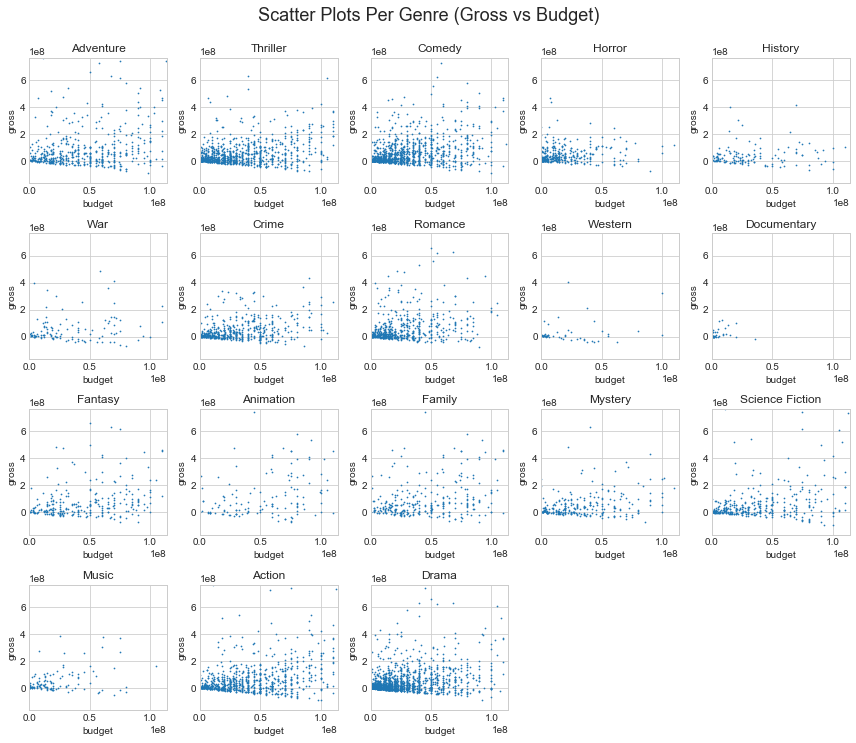

In [22]:
# plot of expense(x) to gross (y)
correlation = {}
i = 1
fig=plt.figure(figsize=(12,12))

xmin = moviedata['budget'].min()
xmax = moviedata['budget'].max()*.3
ymin = moviedata['gross'].min()
ymax = moviedata['gross'].max()*.3

for genre in genres:
    plt.subplot(5, 5, i)
    i = i + 1
    plt.scatter(genres[genre]['budget'],genres[genre]['gross'],.5)
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(genre)
    plt.xlabel('budget')
    plt.ylabel('gross')
    
    correlation[genre] = (genres[genre]['budget'].corr(genres[genre]['gross']))

fig.suptitle('Scatter Plots Per Genre (Gross vs Budget)', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

_ __Answer to Q3:__ The scatter plots show a better visualization of the outliers. A comparatively large number of Western films seem to have lost money. War films appear to have a wider range of profit (and or loss)._

__B. Correlation Heat Map__

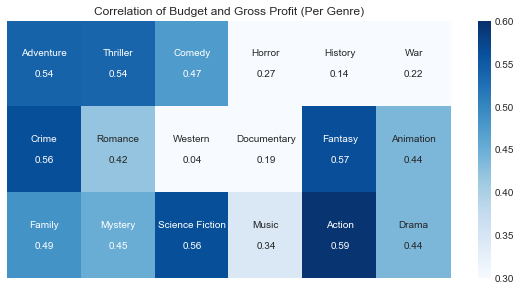

In [23]:
corr = np.array((list(correlation.values())))
labels = (np.asarray(["{}\n\n{:.2f}".format(string, value) \
        for string, value in zip(list(correlation.keys()),corr)])).reshape(3, 6)

fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(corr.reshape(3,6), 
            annot=labels, 
            square=False, 
            ax=ax, 
            fmt="", 
            xticklabels=False, 
            yticklabels=False, 
            cmap="Blues", 
            vmin=.3, 
            vmax=.6)
plt.tight_layout()
plt.title('Correlation of Budget and Gross Profit (Per Genre)')
plt.show()

_ __Answer to Q3:__ Genres that are dark blue (Action, Fantasy, Science Fiction) have the highest correlation between budget and profit. <br>Genres that are white (Western, Horror, War, and History) have low correlation between budget and profit._

------------------

__NOTES__

Samples Comparison Test Chart: https://courses.thinkful.com/data-201v1/assignment/5.5.1

------

# <span style="color:darkblue">Extra Analysis</span>

### Check Normality for Each Genre: <span style="color:darkred">Vote\_Average</span>

__A. Histogram__

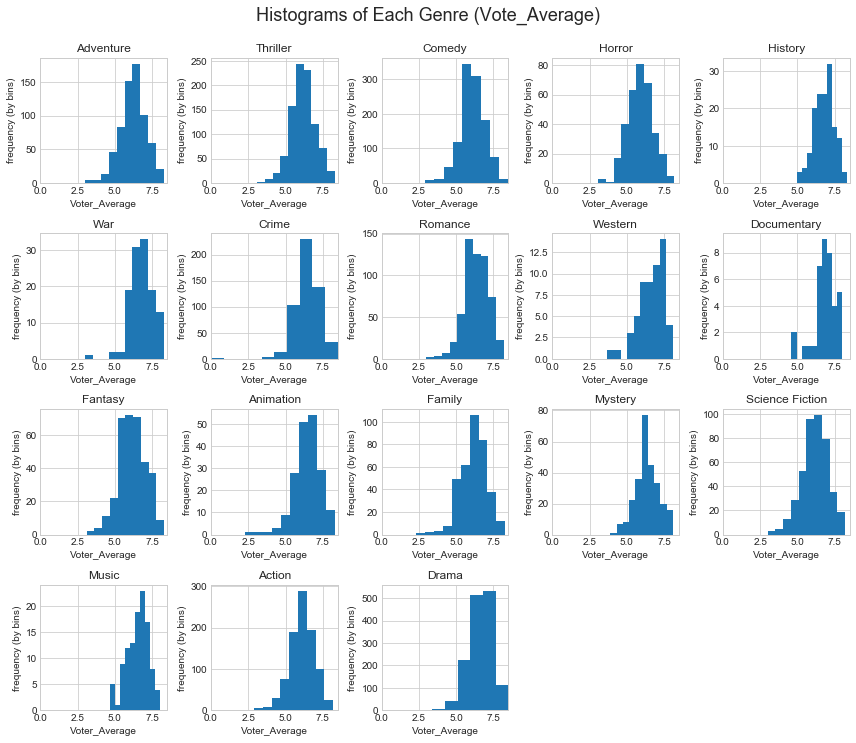

In [24]:
# hist plot of diff genres gross profits
i = 1
fig=plt.figure(figsize=(12,12))

xmin = moviedata['vote_average'].min()
xmax = moviedata['vote_average'].max()
for genre in genres:
    plt.subplot(5, 5, i)
    
    i = i + 1
    plt.hist(genres[genre]['vote_average'],bins=10)
    plt.xlim(xmin,xmax)
    plt.xlabel('Voter_Average')
    plt.ylabel('frequency (by bins)')
    plt.title(genre)

fig.suptitle('Histograms of Each Genre (Vote_Average)', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

_Most Histograms show normality. Some Western and Documentary genres appear to be skewed right._

__B. QQ Gaussian Plot__

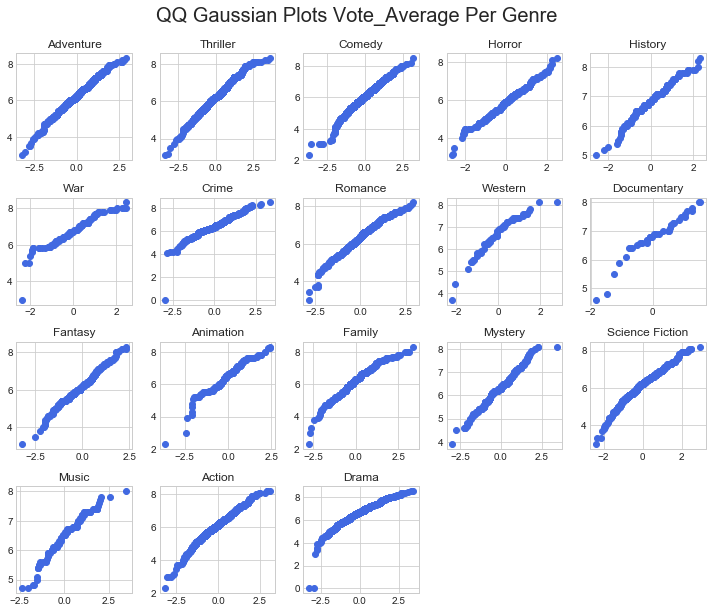

In [25]:
# qq plots of genres for vote_averages
i = 1
fig=plt.figure(figsize=(10,10))

for genre in genres:
    plot_qq(genres[genre]['vote_average'],i)
    i = i + 1
    plt.title(genre)

fig.suptitle('QQ Gaussian Plots Vote_Average Per Genre', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

_QQ plots of genres by vote_ \__average are linear and match the normal sample (with the exception of War and Western)_

__C. Histogram Stacking (Parametric A/B Independent Samples)__

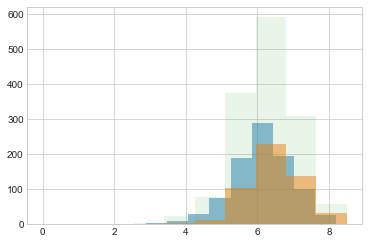

In [26]:
# example hist stacking of voting_average

plt.hist(genres['Action']['vote_average'],bins=10,alpha=0.5)
plt.hist(genres['Crime']['vote_average'],bins=10,alpha=0.5)

total = pd.concat([genres['Action']['vote_average'],genres['Crime']['vote_average']])
plt.hist(total,bins=10,alpha=0.1)
plt.show()

_Stacking histograms to check for overlap_

__D. T-test (Parametric A/B Independent Samples)__ https://courses.thinkful.com/data-201v1/assignment/5.5.1

In [27]:
#Ex T-Test with scipy for parametric, (equal_var=True because same population)
t, p = ttest_ind(genres['Crime']['vote_average'], genres['Action']['vote_average'], equal_var=True)
print('tvalue: {}, pvalue:{}'.format(t,p))

tvalue: 6.671594491458395, pvalue:3.6009251585734e-11


In [28]:
# T-Test Raw Calculation for parametric data

# Compute the difference between the two sample means.
diff=dfGenre.loc['Crime','vote_average_avg'] - dfGenre.loc['Action','vote_average_avg']

# size of samples
size = np.array([dfGenre.loc['Crime','vote_average_cnt'], dfGenre.loc['Action','vote_average_cnt']])
# sample distribution
sd = np.array([dfGenre.loc['Crime','vote_average_std'], dfGenre.loc['Action','vote_average_std']])

# The squared standard deviations are divided by the sample size and summed, then we take
# the square root of the sum. 
diff_se = (sum(sd ** 2 / size)) ** 0.5

print(diff/diff_se)

6.761172745982536


_T-value is 6.71 and p-value is less than 5%. Indicates variation between the Crime and Action._